In [1]:
from astral import LocationInfo
from astral.sun import sun
import datetime as dt
from pathlib import Path  
import pytz
from pytz import timezone
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
from scipy import stats
from scipy.stats import median_test
from scipy.stats import shapiro
import seaborn as sns
import statistics
from statsmodels.stats.diagnostic import lilliefors
import swifter
from swifter import set_defaults
import sys

In [2]:
# set swifter defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=True,
    force_parallel=False,
)

# set seaborn defauly figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Import Data

In [3]:
master = pd.read_csv('./data/hawaii_data/processed/master_hawaii.csv')

meta = pd.read_csv('./data/meta_data.csv')

In [4]:
master.info()
master

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794390 entries, 0 to 1794389
Data columns (total 19 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   Id                             int64  
 2   Datetime (UTC-10)              object 
 3   Hour (UTC-10)                  int64  
 4   Time of Day                    object 
 5   Depth(m)                       float64
 6   External Temp (c)              float64
 7   Sex                            object 
 8   Shark Length (cm)              float64
 9   Time of Day (Astral)           object 
 10  Depth Diff (m)                 float64
 11  Vertical Velocity (m/s)        float64
 12  Speed (m/s)                    float64
 13  Moon Phase                     object 
 14  Mean Hourly Depth (m)          float64
 15  Mean Hourly External Temp (c)  float64
 16  Hourly Diving Ratio            float64
 17  Mean Hourly Speed (m/s)        float64
 18  Da

,Unnamed: 0,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Vertical Velocity (m/s),Speed (m/s),Moon Phase,Mean Hourly Depth (m),Mean Hourly External Temp (c),Hourly Diving Ratio,Mean Hourly Speed (m/s),Daily SST Est (c)
0,0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk,-2.0,1.0,0.016667,New Moon,38.400000,24.600002,1.000000,0.016667,24.75000
1,1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk,-3.0,1.0,0.025000,New Moon,77.166667,23.610001,1.000000,0.056111,24.75000
2,2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk,-4.0,1.0,0.033333,New Moon,77.166667,23.610001,1.000000,0.056111,24.75000
3,3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk,-6.0,1.0,0.050000,New Moon,77.166667,23.610001,1.000000,0.056111,24.75000
4,4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk,-9.0,1.0,0.075000,New Moon,77.166667,23.610001,1.000000,0.056111,24.75000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794385,1794385,190900200,2009-06-09 13:59:10-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,1.0,0.050000,Full Moon,412.559722,8.531944,0.740947,0.085376,25.14375
1794386,1794386,190900200,2009-06-09 13:59:20-10:00,13,Day,405.3,8.700000,F,427.0,Day,-0.5,1.0,0.050000,Full Moon,412.559722,8.531944,0.740947,0.085376,25.14375
1794387,1794387,190900200,2009-06-09 13:59:30-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.0,0.0,0.000000,Full Moon,412.559722,8.531944,0.740947,0.085376,25.14375
1794388,1794388,190900200,2009-06-09 13:59:40-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,1.0,0.050000,Full Moon,412.559722,8.531944,0.740947,0.085376,25.14375


In [5]:
meta.info()
meta

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   eventid                 6 non-null      int64  
 1   tagnumber               6 non-null      object 
 2   ptt                     6 non-null      int64  
 3   taggingdate             6 non-null      object 
 4   length                  6 non-null      float64
 5   sex                     6 non-null      object 
 6   firstdate               6 non-null      object 
 7   lastdate                6 non-null      object 
 8   Sampling Period (sec)   6 non-null      int64  
 9   Max Depth Recorded (m)  6 non-null      float64
dtypes: float64(2), int64(3), object(5)
memory usage: 608.0+ bytes


,eventid,tagnumber,ptt,taggingdate,length,sex,firstdate,lastdate,Sampling Period (sec),Max Depth Recorded (m)
0,190000400,00P0291,29711,2000-10-16,457.00,M,01/03/2001 05:00,04/16/2001 05:00,120,612.0
1,190400900,04P0160,52933,2004-11-30,396.00,F,03/22/2005 05:00,06/10/2005 05:00,60,981.1
2,190502800,05P0132,62021,2005-12-15,480.00,F,03/31/2006 05:00,05/30/2006 05:00,60,549.1
3,190600200,05P0059,60983,2006-01-21,400.00,F,06/09/2006 05:00,09/03/2006 05:00,60,580.8
4,190601200,06A0555,68281,2006-10-10,426.72,M,02/09/2007 05:00,06/05/2007 05:00,15,691.5
5,190900200,08A0599,87568,2009-01-19,427.00,F,03/17/2009 05:00,06/09/2009 05:00,10,990.9


# Statisitcal Tests for Individuals (Depth)

## 190000400 
(Male, 457 cm)

In [6]:
sh = master[master['Id'] == 190000400]
sh

,Unnamed: 0,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Vertical Velocity (m/s),Speed (m/s),Moon Phase,Mean Hourly Depth (m),Mean Hourly External Temp (c),Hourly Diving Ratio,Mean Hourly Speed (m/s),Daily SST Est (c)
0,0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk,-2.0,1.0,0.016667,New Moon,38.400000,24.600002,1.000000,0.016667,24.750000
1,1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk,-3.0,1.0,0.025000,New Moon,77.166667,23.610001,1.000000,0.056111,24.750000
2,2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk,-4.0,1.0,0.033333,New Moon,77.166667,23.610001,1.000000,0.056111,24.750000
3,3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk,-6.0,1.0,0.050000,New Moon,77.166667,23.610001,1.000000,0.056111,24.750000
4,4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk,-9.0,1.0,0.075000,New Moon,77.166667,23.610001,1.000000,0.056111,24.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70705,70705,190000400,2001-04-15 23:49:50-10:00,23,Night,143.6,18.000000,M,457.0,Night,94.0,1.0,0.783333,Full Moon,190.910345,17.648277,0.964286,0.588690,23.800002
70706,70706,190000400,2001-04-15 23:51:50-10:00,23,Night,49.6,21.150002,M,457.0,Night,-112.0,1.0,0.933333,Full Moon,190.910345,17.648277,0.964286,0.588690,23.800002
70707,70707,190000400,2001-04-15 23:53:50-10:00,23,Night,161.6,20.700001,M,457.0,Night,-130.0,1.0,1.083333,Full Moon,190.910345,17.648277,0.964286,0.588690,23.800002
70708,70708,190000400,2001-04-15 23:55:50-10:00,23,Night,291.6,16.500000,M,457.0,Night,68.0,1.0,0.566667,Full Moon,190.910345,17.648277,0.964286,0.588690,23.800002


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


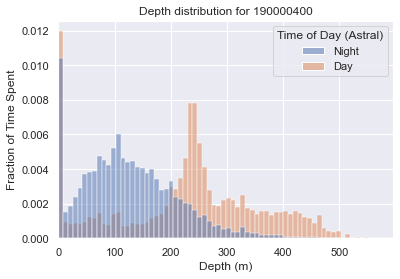

In [7]:
# Plot the overall depth distribution for day and night

# filter out transition states (leaving only deep day or deep night)
filtered = sh.loc[(sh['Time of Day (Astral)'] == 'Day') | (sh['Time of Day (Astral)'] == 'Night')]

# Plot a histogram and color by 'Time of Day (Astral)'
ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, filtered["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190000400')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


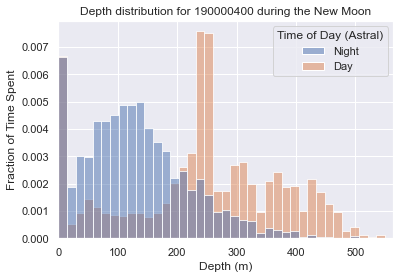

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


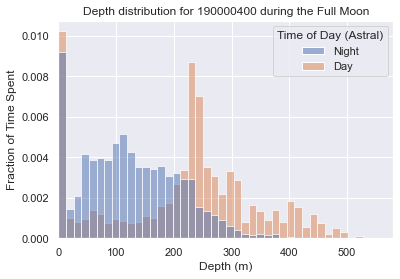

In [8]:
# Plot the depth distribution during different moon phases to see if lunar cycle has an effect on this shark's depth distribution

# filter out transition states 'First Quarter' and 'Last Quarter'
new_moon = filtered[filtered['Moon Phase'] == 'New Moon']
full_moon = filtered[filtered['Moon Phase'] == 'Full Moon']

# Plot a histogram and color by 'Time of Day (Astral)'
ax = sns.histplot(new_moon, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, new_moon["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190000400 during the New Moon')
plt.show()

ax = sns.histplot(full_moon, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, full_moon["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190000400 during the Full Moon')
plt.show()

In [9]:
full_night = full_moon[full_moon['Time of Day (Astral)'] == 'Night']
new_night = new_moon[new_moon['Time of Day (Astral)'] == 'Night']

q3, q1 = np.percentile(full_night['Depth(m)'], [75 ,25])
iqr = q3 - q1

statistics.median(full_night['Depth(m)']), iqr/2

(117.8, 63.175)

In [10]:
q3, q1 = np.percentile(new_night['Depth(m)'], [75 ,25])
iqr = q3 - q1

statistics.median(new_night['Depth(m)']), iqr/2

(121.7, 57.0)

In [11]:
new_night['Depth(m)'].mean(), statistics.stdev(new_night['Depth(m)']), full_night['Depth(m)'].mean(), statistics.stdev(full_night['Depth(m)'])

(131.47058012953013, 89.21143295390009, 124.59566837447599, 83.69532405693525)

In [13]:
# Now day
full_day = full_moon[full_moon['Time of Day (Astral)'] == 'Day']
new_day = new_moon[new_moon['Time of Day (Astral)'] == 'Day']

q3, q1 = np.percentile(full_day['Depth(m)'], [75 ,25])
iqr = q3 - q1

statistics.median(full_day['Depth(m)']), iqr/2

(236.1, 81.42500000000001)

In [14]:
q3, q1 = np.percentile(new_day['Depth(m)'], [75 ,25])
iqr = q3 - q1

statistics.median(new_day['Depth(m)']), iqr/2

(248.2, 79.94999999999999)

In [16]:
new_day['Depth(m)'].mean(), statistics.stdev(new_day['Depth(m)']), full_day['Depth(m)'].mean(), statistics.stdev(full_day['Depth(m)'])

(243.41953954253248, 130.7727560522667, 216.64741200828155, 127.78289084518855)

In [17]:
# Lunar cycle does not seem to have a strong effect on depth distribution for this shark. By eye, metrics that may be significantly different include: mean or median depth during day vs night OR 
# distribution shape/type during day vs night (this does not necesarrily mean that mean/median depth are significantly different). Since we are focusing on diving behavior, it would make
# sense to filter out data points from the top 5-10 meters since there are many points in this region that could skew both day/night sample distributions. Then, although the distributions don't
# appear normal, a normality test for sanity would reduce the scope of best metrics and statistical tests that an be used to compare the two distributions. If the distributions are normal,
# they can be compared with parametric tests, which in most cases can be stronger tests than non-parametric tests. However, in the likely case that the two distributions are not normal,
# we must use non-parametric tests to compare the day/night samples.
# 
# In the case that both samples are normal, a  p-value from a comparison of means test (parametric test) would be a good indication of significant difference. However, in the case that both samples are not 
# normal, a p-value from a comparison of medians (non-parametric test) would be a good indication of significant difference (though less strong that comparison of means). If the medians are not significantly 
# different, we can perform a KS test (non-parametric) to determine whether the shape of the distributions themselves are significantly different (reguardless of the normality of both distributions).

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


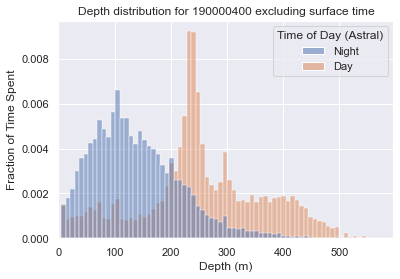

In [18]:
#  1 - filter out surface datapoints (top 5m of water) and visualize

filtered = filtered[filtered['Depth(m)'] > 5]

ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, filtered["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190000400 excluding surface time')
plt.show()

In [19]:
# Since filtering out sample data shallower than 5 m in depth got rid of the abnormal spikes in the depth distribution, we can move on to the normaility test.

In [20]:
# 1 - Test both samples for normality to determine whether parametric or non-parametric tests should be used to compare the samples.
# The Shapiro–Wilk test is more appropriate method for small sample sizes (<50 samples) although it can also be handling on larger sample size while Kolmogorov–Smirnov test is used for n ≥50.
# The Scipy Sharpiro test is not accurate for samples larger than 5000. We will test it anyways, and for this test, a p-value of less than 0.05 means that the distribution is normal. 
# However, the Lilliefors test is a normality test based on the Kolmogorov–Smirnov test. As all the above methods, this test is used to check if the data come from a normal distribution for
# samples > 5000 datapoints. For the Lilliefors test, ff the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
# If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.


day_depths = filtered[filtered['Time of Day (Astral)'] == 'Day']['Depth(m)']
night_depths = filtered[filtered['Time of Day (Astral)'] == 'Night']['Depth(m)']

day_depths, night_depths, shapiro(day_depths), shapiro(night_depths) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(394      252.4
 395      248.4
 396      252.4
 397      252.4
 398      248.4
          ...  
 70521    347.6
 70522    355.6
 70523    299.6
 70524    267.6
 70525    299.6
 Name: Depth(m), Length: 25792, dtype: float64,
 5         62.4
 6         65.4
 7         64.4
 8         61.4
 9         64.4
          ...  
 70705    143.6
 70706     49.6
 70707    161.6
 70708    291.6
 70709    223.6
 Name: Depth(m), Length: 27866, dtype: float64,
 ShapiroResult(statistic=0.9784955382347107, pvalue=0.0),
 ShapiroResult(statistic=0.9549441933631897, pvalue=0.0))

In [21]:
# Lillifors
stat,p = lilliefors(day_depths)
stat_2,p_2 = lilliefors(night_depths)

stat, p, stat_2, p_2

(0.07771909072662364,
 0.0009999999999998899,
 0.06832537830630658,
 0.0009999999999998899)

In [22]:
# According to Lillifors, the distributions are not normal. We disreguard the p-value from the Shapiro-Wilk normality test because it is clearly innaccurate for our sample size. We continue using non-parametric
# tests. First, we will perform a comparison of medians test. If the medians are not significantly different, we can compare the distributions shapes with a KS test.

In [23]:
# print the medians just for reference - we can proabably tell ourselves if they are significantly difference but the tests will be performed reguardless for sanity
statistics.median(day_depths), statistics.median(night_depths)


(244.2, 126.0)

In [24]:
q3, q1 = np.percentile(day_depths, [75 ,25])
iqr = q3 - q1
iqr/2

60.05

In [25]:
q3, q1 = np.percentile(night_depths, [75 ,25])
iqr = q3 - q1
iqr/2

53.35

In [26]:
# The medians seem pretty different. Now we can move onto non-parametric tests. First, we will do a comparison of medians. If the medians are not significatly different,
# we can compare the shape of the sample distributions using a KS-test. If the shapes are different enough (via p-value), we can say that the samples are from different distributions

In [27]:
# 2 - Since both samples are non-Gaussian, compare them using non parametric tests. Since the medians seem pretty different, we begin with a difference of medians.
# Scientific experiments often consist of comparing two or more sets of data. This data is described as unpaired or independent when the sets of data arise from 
# separate individuals or paired when it arises from the same individual at different points in time. The Wilcoxon signed-rank test is a nonparametric test
# for comparing paired data samples (the nonparametric version of the paired Student t-test). It is better than the Wilcoxon rank-sum for this scenario because
# Wilcoxon rank-sum test is used to compare two independent samples, while Wilcoxon signed-rank test is used to compare two related samples, matched samples, 
# or to conduct a paired difference test of repeated measurements on a single sample to assess whether their population mean ranks differ.
# For the Wilcoxon Signed Rank test to be effective, it requires at least 20 observations in each data sample, which we have (by far).

from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import random
from random import sample

# samples must be same size to perform wilcoxon signed rank. In this case, we know that there are 25,792 datapoints in the day_depth sample
# and 27,866 in the night_depths sample. We randomly resample (without replacement) the larger sample to match the size of the smaller one.
wilcox_night = sample(list(night_depths), len(day_depths))

# case p > 0.05: Samples come from the same distribution (fail to reject H_0)
# else p <= 0.05 : Samples come from different distribution (reject H0)

# traditional median comparison followed by wilcoxon signed-rank test
stat, p, med, tbl = median_test(list(day_depths), list(night_depths))
stat_2, p_2 = wilcoxon(day_depths, wilcox_night)
stat_3, p_3 = mannwhitneyu(day_depths, wilcox_night) # Mann whitney is more powerful

stat, '{0:.16f}'.format(p), med, tbl, stat_2, '{0:.16f}'.format(p_2), stat_3, '{0:.16f}'.format(p_3)

(16086.222371976872,
 '0.0000000000000000',
 189.9,
 array([[20233,  6590],
        [ 5559, 21276]]),
 39011565.5,
 '0.0000000000000000',
 535718183.5,
 '0.0000000000000000')

In [28]:
# that's funny - both a p-value of zero. Seems a little fishy. While not listed in their documentation, while the Wilcoxon signed-rank test in general doesn't assume any distribution, 
# most exact implementations are restricted to <50 samples (i.e. scipy). Let's try a different test. Since KS test can be used for large samples, let's try that to compare the distributions

stat, p = stats.kstest(day_depths, night_depths)
stat, '{0:.16f}'.format(p)

(0.5562650339519206, '0.0000000000000000')

In [29]:
# Seems fishy... upon further exploration, I found this paper: https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-12-78.
# The conclusion:
# "Non-parametric tests are most useful for small studies. Using non-parametric tests in large studies may provide answers to the wrong question, 
# thus confusing readers. For studies with a large sample size, t-tests and their corresponding confidence intervals can and should be used even 
# for heavily skewed data."
# From the Discussion:
# "With a large sample size, the WMW test has great power to detect that that probability is not 50%. If the purpose of the study is to detect 
# any distributional difference, using a non-parametric test is probably useful. Most studies, however, are carried out to investigate differences 
# in means or medians, and as such, the ratio of non-parametric tests to t-tests ought to decrease when studies grow in size."

# Let's try a t-test to look at the difference in means of the daytime and nighttime depth samples for shark 190000400

In [30]:
# First, let's just see the means of both
day_depths.mean(), statistics.stdev(day_depths), night_depths.mean(), statistics.stdev(night_depths)

(255.20298929900744, 111.20149134307127, 138.84384195794158, 79.53004664712726)

In [31]:
# The means look pretty different. Let's test that with a paired t-test
stat, p = stats.ttest_rel(day_depths, wilcox_night) # sample len must be same
stat, '{0:.16f}'.format(p)

(136.2395627831587, '0.0000000000000000')

In [32]:
# unpaired t-test
stat, p = stats.ttest_ind(day_depths, wilcox_night, equal_var=False)
stat, '{0:.16f}'.format(p)

(136.6024842978686, '0.0000000000000000')

## 190601200 
(M, 426.72 cm)

In [33]:
sh = master[master['Id'] == 190601200]
sh

,Unnamed: 0,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Vertical Velocity (m/s),Speed (m/s),Moon Phase,Mean Hourly Depth (m),Mean Hourly External Temp (c),Hourly Diving Ratio,Mean Hourly Speed (m/s),Daily SST Est (c)
394710,394710,190601200,2007-02-08 14:00:00-10:00,14,Day,254.5,16.05,M,426.72,Day,2.0,1.0,0.133333,Full Moon,186.506250,20.040625,0.920833,0.150556,24.25
394711,394711,190601200,2007-02-08 14:00:15-10:00,14,Day,252.5,16.65,M,426.72,Day,1.0,1.0,0.066667,Full Moon,186.506250,20.040625,0.920833,0.150556,24.25
394712,394712,190601200,2007-02-08 14:00:30-10:00,14,Day,251.5,16.65,M,426.72,Day,-1.5,1.0,0.100000,Full Moon,186.506250,20.040625,0.920833,0.150556,24.25
394713,394713,190601200,2007-02-08 14:00:45-10:00,14,Day,253.0,16.60,M,426.72,Day,-4.5,1.0,0.300000,Full Moon,186.506250,20.040625,0.920833,0.150556,24.25
394714,394714,190601200,2007-02-08 14:01:00-10:00,14,Day,257.5,15.20,M,426.72,Day,-3.0,1.0,0.200000,Full Moon,186.506250,20.040625,0.920833,0.150556,24.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068625,1068625,190601200,2007-06-05 13:58:45-10:00,13,Day,242.7,15.55,M,426.72,Day,12.0,1.0,0.800000,Full Moon,267.020833,14.422292,1.000000,0.772803,26.10
1068626,1068626,190601200,2007-06-05 13:59:00-10:00,13,Day,230.7,16.05,M,426.72,Day,12.5,1.0,0.833333,Full Moon,267.020833,14.422292,1.000000,0.772803,26.10
1068627,1068627,190601200,2007-06-05 13:59:15-10:00,13,Day,218.2,16.40,M,426.72,Day,10.5,1.0,0.700000,Full Moon,267.020833,14.422292,1.000000,0.772803,26.10
1068628,1068628,190601200,2007-06-05 13:59:30-10:00,13,Day,207.7,17.00,M,426.72,Day,10.5,1.0,0.700000,Full Moon,267.020833,14.422292,1.000000,0.772803,26.10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


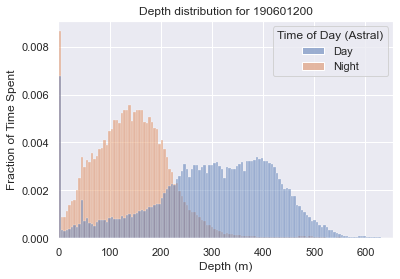

In [34]:
# Plot the overall depth distribution for day and night

# filter out transition states (leaving only deep day or deep night)
filtered = sh.loc[(sh['Time of Day (Astral)'] == 'Day') | (sh['Time of Day (Astral)'] == 'Night')]

# Plot a histogram and color by 'Time of Day (Astral)'
ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, filtered["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190601200')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


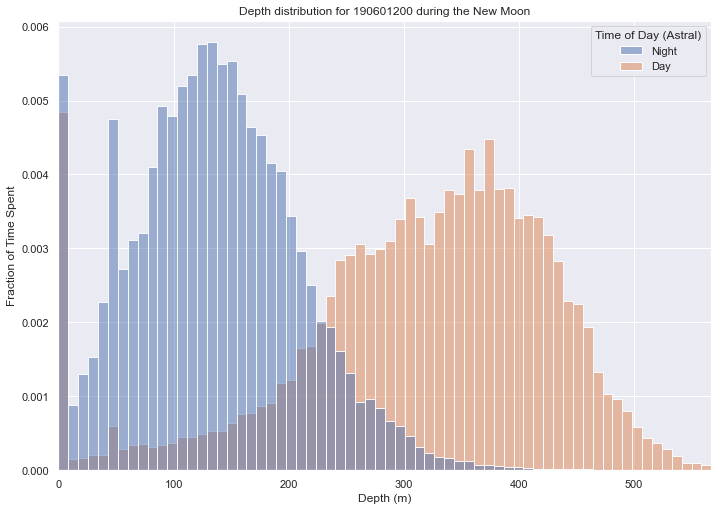

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


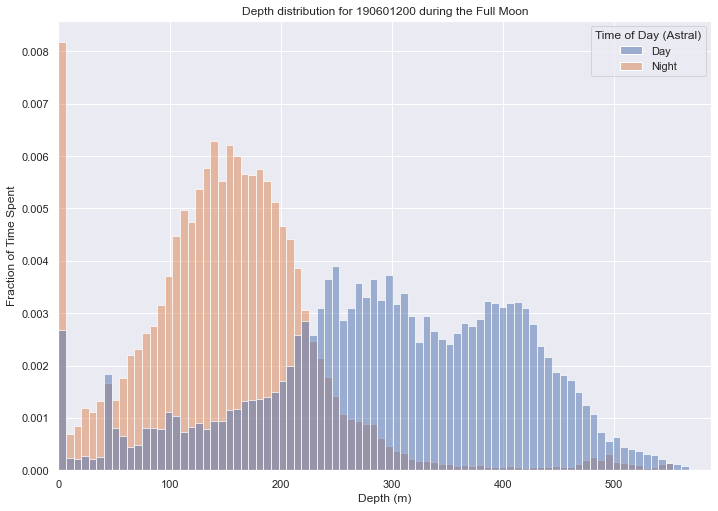

In [35]:
# Plot the depth distribution during different moon phases to see if lunar cycle has an effect on this shark's depth distribution

# filter out transition states 'First Quarter' and 'Last Quarter'
new_moon = filtered[filtered['Moon Phase'] == 'New Moon']
full_moon = filtered[filtered['Moon Phase'] == 'Full Moon']

# Plot a histogram and color by 'Time of Day (Astral)'
ax = sns.histplot(new_moon, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, new_moon["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190601200 during the New Moon')
plt.show()

ax = sns.histplot(full_moon, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, full_moon["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190601200 during the Full Moon')
plt.show()

In [36]:
full_night = full_moon[full_moon['Time of Day (Astral)'] == 'Night']
new_night = new_moon[new_moon['Time of Day (Astral)'] == 'Night']

statistics.median(new_night['Depth(m)']), new_night['Depth(m)'].mean(), statistics.median(full_night['Depth(m)']), full_night['Depth(m)'].mean()

(133.2, 135.48837670673356, 151.5, 152.0866905740692)

In [37]:
full_day = full_moon[full_moon['Time of Day (Astral)'] == 'Day']
new_day = new_moon[new_moon['Time of Day (Astral)'] == 'Day']

statistics.median(new_day['Depth(m)']), new_day['Depth(m)'].mean(), statistics.median(full_day['Depth(m)']), full_day['Depth(m)'].mean()

(332.0, 313.05674020364086, 301.2, 296.41329787939475)

In [38]:
# Lunar cycle does not seem to have a strong effect on depth distribution for this shark. By eye, metrics that may be significantly different include: mean or median depth during day vs night OR 
# distribution shape/type during day vs night (this does not necesarrily mean that mean/median depth are significantly different). Since we are focusing on diving behavior, it would make
# sense to filter out data points from the top 5-10 meters since there are many points in this region that could skew both day/night sample distributions. Then, although the distributions don't
# appear normal, a normality test for sanity would reduce the scope of best metrics and statistical tests that an be used to compare the two distributions. If the distributions are normal,
# they can be compared with parametric tests, which in most cases can be stronger tests than non-parametric tests. However, in the likely case that the two distributions are not normal,
# we must use non-parametric tests to compare the day/night samples.
# 
# In the case that both samples are normal, a  p-value from a comparison of means test (parametric test) would be a good indication of significant difference. However, in the case that both samples are not 
# normal, a p-value from a comparison of medians (non-parametric test) would be a good indication of significant difference (though less strong that comparison of means). If the medians are not significantly 
# different, we can perform a KS test (non-parametric) to determine whether the shape of the distributions themselves are significantly different (reguardless of the normality of both distributions).

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


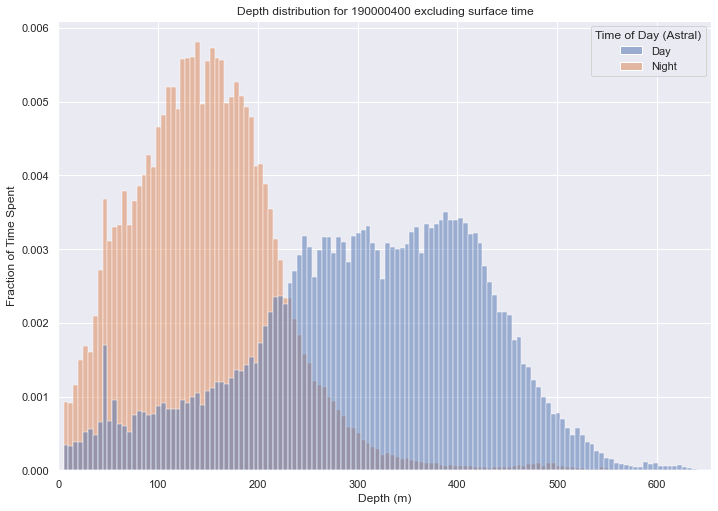

In [39]:
#  1 - filter out surface datapoints (top 5m of water) and visualize

filtered = filtered[filtered['Depth(m)'] > 5]

ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, filtered["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190000400 excluding surface time')
plt.show()

In [ ]:
# Since filtering out sample data shallower than 5 m in depth got rid of the abnormal spikes in the depth distribution, we can move on to the normaility test.

In [ ]:
# 1 - Test both samples for normality to determine whether parametric or non-parametric tests should be used to compare the samples.
# The Shapiro–Wilk test is more appropriate method for small sample sizes (<50 samples) although it can also be handling on larger sample size while Kolmogorov–Smirnov test is used for n ≥50.
# The Scipy Sharpiro test is not accurate for samples larger than 5000. We will test it anyways, and for this test, a p-value of less than 0.05 means that the distribution is normal. 
# However, the Lilliefors test is a normality test based on the Kolmogorov–Smirnov test. As all the above methods, this test is used to check if the data come from a normal distribution for
# samples > 5000 datapoints. For the Lilliefors test, ff the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
# If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.


day_depths = filtered[filtered['Time of Day (Astral)'] == 'Day']['Depth(m)']
night_depths = filtered[filtered['Time of Day (Astral)'] == 'Night']['Depth(m)']

day_depths, night_depths, shapiro(day_depths), shapiro(night_depths) 

In [ ]:
# Lillifors
stat,p = lilliefors(day_depths)
stat_2,p_2 = lilliefors(night_depths)

stat, p, stat_2, p_2

In [ ]:
# According to Lillifors, the distributions are not normal. We disreguard the p-value from the Shapiro-Wilk normality test because it is clearly innaccurate for our sample size. We continue using non-parametric
# tests. First, we will perform a comparison of medians test. If the medians are not significantly different, we can compare the distributions shapes with a KS test.

In [ ]:
# print the medians just for reference - we can proabably tell ourselves if they are significantly difference but the tests will be performed reguardless for sanity
statistics.median(day_depths), statistics.median(night_depths)


In [ ]:
# The medians seem pretty different. Now we can move onto non-parametric tests. First, we will do a comparison of medians. If the medians are not significatly different,
# we can compare the shape of the sample distributions using a KS-test. If the shapes are different enough (via p-value), we can say that the samples are from different distributions

In [ ]:
len(night_depths), len(day_depths)

In [ ]:
# 2 - Since both samples are non-Gaussian, compare them using non parametric tests. Since the medians seem pretty different, we begin with a difference of medians.
# Scientific experiments often consist of comparing two or more sets of data. This data is described as unpaired or independent when the sets of data arise from 
# separate individuals or paired when it arises from the same individual at different points in time. The Wilcoxon signed-rank test is a nonparametric test
# for comparing paired data samples (the nonparametric version of the paired Student t-test). It is better than the Wilcoxon rank-sum for this scenario because
# Wilcoxon rank-sum test is used to compare two independent samples, while Wilcoxon signed-rank test is used to compare two related samples, matched samples, 
# or to conduct a paired difference test of repeated measurements on a single sample to assess whether their population mean ranks differ.
# For the Wilcoxon Signed Rank test to be effective, it requires at least 20 observations in each data sample, which we have (by far).

from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import random
from random import sample

# samples must be same size to perform wilcoxon signed rank. In this case, we know that there are 25,792 datapoints in the day_depth sample
# and 27,866 in the night_depths sample. We randomly resample (without replacement) the larger sample to match the size of the smaller one.
wilcox_day = sample(list(day_depths), len(night_depths))

# case p > 0.05: Samples come from the same distribution (fail to reject H_0)
# else p <= 0.05 : Samples come from different distribution (reject H0)

# traditional median comparison followed by wilcoxon signed-rank test
stat, p, med, tbl = median_test(list(day_depths), list(night_depths))
stat_2, p_2 = wilcoxon(wilcox_day, night_depths)
stat_3, p_3 = mannwhitneyu(wilcox_day, night_depths) # Mann whitney is more powerful

stat, '{0:.16f}'.format(p), med, tbl, stat_2, '{0:.16f}'.format(p_2), stat_3, '{0:.16f}'.format(p_3)

In [ ]:
# that's funny - both a p-value of zero. Seems a little fishy. While not listed in their documentation, while the Wilcoxon signed-rank test in general doesn't assume any distribution, 
# most exact implementations are restricted to <50 samples (i.e. scipy). Let's try a different test. Since KS test can be used for large samples, let's try that to compare the distributions

stat, p = stats.kstest(day_depths, night_depths)
stat, '{0:.16f}'.format(p)

In [ ]:
# Seems fishy... upon further exploration, I found this paper: https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-12-78.
# The conclusion:
# "Non-parametric tests are most useful for small studies. Using non-parametric tests in large studies may provide answers to the wrong question, 
# thus confusing readers. For studies with a large sample size, t-tests and their corresponding confidence intervals can and should be used even 
# for heavily skewed data."
# From the Discussion:
# "With a large sample size, the WMW test has great power to detect that that probability is not 50%. If the purpose of the study is to detect 
# any distributional difference, using a non-parametric test is probably useful. Most studies, however, are carried out to investigate differences 
# in means or medians, and as such, the ratio of non-parametric tests to t-tests ought to decrease when studies grow in size."

# Let's try a t-test to look at the difference in means of the daytime and nighttime depth samples for shark 190000400

In [ ]:
# First, let's just see the means of both
day_depths.mean(), night_depths.mean()

In [ ]:
# The means look pretty different. Let's test that with a paired t-test

# This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
# If we observe a large p-value, for example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores. 
# If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.
stat, p = stats.ttest_rel(wilcox_day, night_depths) # sample len must be same
stat, '{0:.16f}'.format(p)

In [ ]:
# unpaired t-test

# A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely 
# to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. 
# If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal 
# population means.
stat, p = stats.ttest_ind(wilcox_day, night_depths, equal_var=False)
stat, '{0:.16f}'.format(p)

## 190400900 
(F, 396 cm)

In [ ]:
sh = master[master['Id'] == 190400900]
sh

In [ ]:
# Plot the overall depth distribution for day and night

# filter out transition states (leaving only deep day or deep night)
filtered = sh.loc[(sh['Time of Day (Astral)'] == 'Day') | (sh['Time of Day (Astral)'] == 'Night')]

# Plot a histogram and color by 'Time of Day (Astral)'
ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, filtered["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190400900')
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.show()

In [ ]:
# Plot the depth distribution during different moon phases to see if lunar cycle has an effect on this shark's depth distribution

# filter out transition states 'First Quarter' and 'Last Quarter'
new_moon = filtered[filtered['Moon Phase'] == 'New Moon']
full_moon = filtered[filtered['Moon Phase'] == 'Full Moon']

# Plot a histogram and color by 'Time of Day (Astral)'
ax = sns.histplot(new_moon, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, new_moon["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190400900 during the New Moon')
plt.show()

ax = sns.histplot(full_moon, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, full_moon["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190400900 during the Full Moon')
plt.show()

In [ ]:
full_night = full_moon[full_moon['Time of Day (Astral)'] == 'Night']
new_night = new_moon[new_moon['Time of Day (Astral)'] == 'Night']

statistics.median(new_night['Depth(m)']), new_night['Depth(m)'].mean(), statistics.median(full_night['Depth(m)']), full_night['Depth(m)'].mean()

In [ ]:
full_day = full_moon[full_moon['Time of Day (Astral)'] == 'Day']
new_day = new_moon[new_moon['Time of Day (Astral)'] == 'Day']

statistics.median(new_day['Depth(m)']), new_day['Depth(m)'].mean(), statistics.median(full_day['Depth(m)']), full_day['Depth(m)'].mean()

In [ ]:
# Lunar cycle does not seem to have a strong effect on depth distribution for this shark. By eye, metrics that may be significantly different include: mean or median depth during day vs night OR 
# distribution shape/type during day vs night (this does not necesarrily mean that mean/median depth are significantly different). Since we are focusing on diving behavior, it would make
# sense to filter out data points from the top 5-10 meters since there are many points in this region that could skew both day/night sample distributions. Then, although the distributions don't
# appear normal, a normality test for sanity would reduce the scope of best metrics and statistical tests that an be used to compare the two distributions. If the distributions are normal,
# they can be compared with parametric tests, which in most cases can be stronger tests than non-parametric tests. However, in the likely case that the two distributions are not normal,
# we must use non-parametric tests to compare the day/night samples.
# 
# In the case that both samples are normal, a  p-value from a comparison of means test (parametric test) would be a good indication of significant difference. However, in the case that both samples are not 
# normal, a p-value from a comparison of medians (non-parametric test) would be a good indication of significant difference (though less strong that comparison of means). If the medians are not significantly 
# different, we can perform a KS test (non-parametric) to determine whether the shape of the distributions themselves are significantly different (reguardless of the normality of both distributions).

In [ ]:
#  1 - filter out surface datapoints (top 5m of water) and visualize

filtered = filtered[filtered['Depth(m)'] > 5]

ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, filtered["Depth(m)"].max())
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190400900 excluding surface time')
plt.show()

In [ ]:
# Since filtering out sample data shallower than 5 m in depth got rid of the abnormal spikes in the depth distribution, we can move on to the normaility test.

In [ ]:
# 1 - Test both samples for normality to determine whether parametric or non-parametric tests should be used to compare the samples.
# The Shapiro–Wilk test is more appropriate method for small sample sizes (<50 samples) although it can also be handling on larger sample size while Kolmogorov–Smirnov test is used for n ≥50.
# The Scipy Sharpiro test is not accurate for samples larger than 5000. We will test it anyways, and for this test, a p-value of less than 0.05 means that the distribution is normal. 
# However, the Lilliefors test is a normality test based on the Kolmogorov–Smirnov test. As all the above methods, this test is used to check if the data come from a normal distribution for
# samples > 5000 datapoints. For the Lilliefors test, ff the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
# If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.


day_depths = filtered[filtered['Time of Day (Astral)'] == 'Day']['Depth(m)']
night_depths = filtered[filtered['Time of Day (Astral)'] == 'Night']['Depth(m)']

day_depths, night_depths, shapiro(day_depths), shapiro(night_depths) 

In [ ]:
# Lillifors
stat,p = lilliefors(day_depths)
stat_2,p_2 = lilliefors(night_depths)

stat, p, stat_2, p_2

In [ ]:
# According to Lillifors, the distributions are not normal. This is obvious from the histogram.
# We disreguard the p-value from the Shapiro-Wilk normality test because it is clearly innaccurate for our sample size. We continue using non-parametric
# tests. First, we will perform a KS test. We do this because the distributions lok like different shapes but it's not obvious
# that their medians/means would come from different distributions if we assumed normality.
# If the the distributions are not significantly different, we can try other non-parametric tests, but it might not be best to 
# use parametric tests in this case. We can always try them anyways

In [ ]:
# that's funny - both a p-value of zero. Seems a little fishy. While not listed in their documentation, while the Wilcoxon signed-rank test in general doesn't assume any distribution, 
# most exact implementations are restricted to <50 samples (i.e. scipy). Let's try a different test. Since KS test can be used for large samples, let's try that to compare the distributions

stat, p = stats.kstest(day_depths, night_depths)
stat, '{0:.16f}'.format(p)

In [ ]:
# print the medians just for reference - we can proabably tell ourselves if they are significantly difference but the tests will be performed reguardless for sanity
statistics.median(day_depths), statistics.median(night_depths)


In [ ]:
# The medians seem pretty different. Now we can move onto non-parametric tests. First, we will do a comparison of medians. If the medians are not significatly different,
# we can compare the shape of the sample distributions using a KS-test. If the shapes are different enough (via p-value), we can say that the samples are from different distributions

In [ ]:
len(night_depths), len(day_depths)

In [ ]:
# 2 - Since both samples are non-Gaussian, compare them using non parametric tests. Since the medians seem pretty different, we begin with a difference of medians.
# Scientific experiments often consist of comparing two or more sets of data. This data is described as unpaired or independent when the sets of data arise from 
# separate individuals or paired when it arises from the same individual at different points in time. The Wilcoxon signed-rank test is a nonparametric test
# for comparing paired data samples (the nonparametric version of the paired Student t-test). It is better than the Wilcoxon rank-sum for this scenario because
# Wilcoxon rank-sum test is used to compare two independent samples, while Wilcoxon signed-rank test is used to compare two related samples, matched samples, 
# or to conduct a paired difference test of repeated measurements on a single sample to assess whether their population mean ranks differ.
# For the Wilcoxon Signed Rank test to be effective, it requires at least 20 observations in each data sample, which we have (by far).

from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import random
from random import sample

# samples must be same size to perform wilcoxon signed rank. In this case, we know that there are 25,792 datapoints in the day_depth sample
# and 27,866 in the night_depths sample. We randomly resample (without replacement) the larger sample to match the size of the smaller one.
wilcox_day = sample(list(day_depths), len(night_depths))

# case p > 0.05: Samples come from the same distribution (fail to reject H_0)
# else p <= 0.05 : Samples come from different distribution (reject H0)

# traditional median comparison followed by wilcoxon signed-rank test
stat, p, med, tbl = median_test(list(day_depths), list(night_depths))
stat_2, p_2 = wilcoxon(wilcox_day, night_depths)
stat_3, p_3 = mannwhitneyu(wilcox_day, night_depths) # Mann whitney is more powerful

stat, '{0:.16f}'.format(p), med, tbl, stat_2, '{0:.16f}'.format(p_2), stat_3, '{0:.16f}'.format(p_3)

In [ ]:
# Seems fishy... upon further exploration, I found this paper: https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-12-78.
# The conclusion:
# "Non-parametric tests are most useful for small studies. Using non-parametric tests in large studies may provide answers to the wrong question, 
# thus confusing readers. For studies with a large sample size, t-tests and their corresponding confidence intervals can and should be used even 
# for heavily skewed data."
# From the Discussion:
# "With a large sample size, the WMW test has great power to detect that that probability is not 50%. If the purpose of the study is to detect 
# any distributional difference, using a non-parametric test is probably useful. Most studies, however, are carried out to investigate differences 
# in means or medians, and as such, the ratio of non-parametric tests to t-tests ought to decrease when studies grow in size."

# Let's try a t-test to look at the difference in means of the daytime and nighttime depth samples for shark 190000400

In [ ]:
# First, let's just see the means of both
day_depths.mean(), night_depths.mean()

In [ ]:
# The means look pretty different. Let's test that with a paired t-test

# This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
# If we observe a large p-value, for example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores. 
# If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.
stat, p = stats.ttest_rel(wilcox_day, night_depths) # sample len must be same
stat, '{0:.16f}'.format(p)

In [ ]:
# unpaired t-test

# A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely 
# to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. 
# If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal 
# population means.
stat, p = stats.ttest_ind(wilcox_day, night_depths, equal_var=False)
stat, '{0:.16f}'.format(p)